# Lab 3 - Naive Bayes and KNN
Here, we are going to analyse two models: Naive Bayes and KNN

Observation: to test them, it's going to be used **k fold cross-validation** with repetition (RepeatedStratifiedKFold), because of the low number of records of the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
import sklearn.metrics as metrics
import itertools
import dataPreparationFunctions as dataPrepare, graphFunctions as graph

In [2]:
data_7: pd.DataFrame = pd.read_csv('datasets/pd_data_preparation_7.csv', sep=',', decimal='.', index_col='id')
y_7: np.ndarray = data_7.pop('class').values
X_7: np.ndarray = data_7.values
labels_7 = pd.unique(y_7)

data_8: pd.DataFrame = pd.read_csv('datasets/pd_data_preparation.csv', sep=',', decimal='.', index_col='id')
y_8: np.ndarray = data_8.pop('class').values
X_8: np.ndarray = data_8.values
labels_8 = pd.unique(y_8)

data_9: pd.DataFrame = pd.read_csv('datasets/pd_data_preparation_9.csv', sep=',', decimal='.', index_col='id')
y_9: np.ndarray = data_9.pop('class').values
X_9: np.ndarray = data_9.values
labels_9 = pd.unique(y_9)

data_8.head()

,gender,PPE,DFA,RPDE,numPulses,stdDevPeriodPulses,locPctJitter,locShimmer,meanAutoCorrHarmonicity,minIntensity,...,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_30
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.916232,0.475707,0.590235,0.284974,0.022323,0.075900,0.271284,0.944323,0.692855,...,0.075621,0.300582,0.105270,0.013066,0.004055,0.003293,0.000374,0.000178,0.000191,0.098628
1,0.0,0.182314,0.806469,0.630075,0.242228,0.689703,0.247423,0.228818,0.876238,0.882924,...,0.072430,0.077755,0.174381,0.038398,0.008310,0.001114,0.001689,0.024783,0.018258,0.040204
2,1.0,0.877689,0.216841,0.516437,0.448187,0.033848,0.087255,0.117413,0.974092,0.871010,...,0.147429,0.038159,0.013139,0.007834,0.019385,0.000201,0.000368,0.000336,0.213153,0.120303
3,0.0,0.925807,0.237611,0.542708,0.785622,0.010547,0.021814,0.161006,0.983185,0.781731,...,0.016141,0.161223,0.097629,0.037870,0.020783,0.009404,0.018881,0.003916,0.000815,0.009216
4,0.0,0.930451,0.757013,0.842307,0.532383,0.754983,0.148962,0.722861,0.734980,0.497109,...,0.142211,0.230036,0.117364,0.022389,0.009184,0.006695,0.009538,0.010617,0.013877,0.010267


## Naive Bayes
Using Z normalization can help a little

Accuracy for: GaussianNB : 0.7828
Sensitivity for: GaussianNB : 0.7199


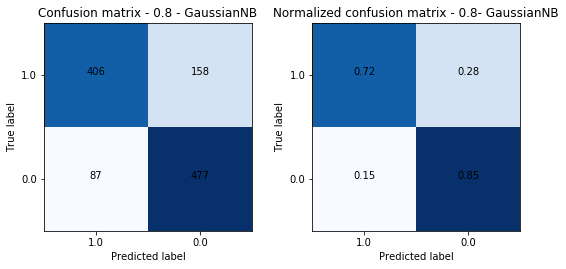

Accuracy for: MultinomialNB : 0.7349
Sensitivity for: MultinomialNB : 0.7518


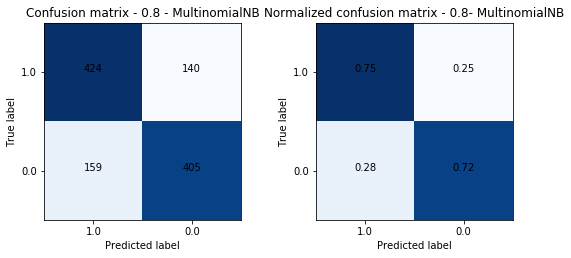

Accuracy for: BernoulyNB : 0.5390
Sensitivity for: BernoulyNB : 0.3670


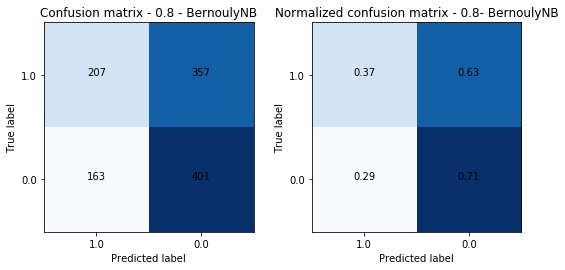

In [3]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
estimators = {'GaussianNB': GaussianNB(), 
              'MultinomialNB': MultinomialNB(), 
              'BernoulyNB': BernoulliNB()}

#todo: review names variables and code
n_splits = 4
n_repeats = 3

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

for clf in estimators:
    accuracy[clf] = 0
    sensitivity[clf] = 0
    cnf_mtx[clf] = np.zeros((2, 2)).astype(int)
    
for train_index, test_index in rskf.split(X_8, y_8):
    X_train, X_test = X_8[train_index], X_8[test_index]
    y_train, y_test = y_8[train_index], y_8[test_index]
    for clf in estimators:
        estimators[clf].fit(X_train, y_train)
        prdY = estimators[clf].predict(X_test)
        accuracy[clf] += metrics.accuracy_score(y_test, prdY)
        sensitivity[clf] += metrics.recall_score(y_test, prdY)
        cnf_mtx[clf] += metrics.confusion_matrix(y_test, prdY, labels_8)
for clf in estimators:
    accuracy[clf] /= n_splits*n_repeats
    sensitivity[clf] /= n_splits*n_repeats
    print("Accuracy for:", clf, ':', format(accuracy[clf], '.4f'))
    print("Sensitivity for:", clf, ':', format(sensitivity[clf], '.4f'))
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
    graph.plot_confusion_matrix(axs[0, 0], cnf_mtx[clf], labels_8, title_complement=('- 0.8 -' + clf))
    graph.plot_confusion_matrix(axs[0, 1], cnf_mtx[clf], labels_8, normalize=True, title_complement=('- 0.8- ' + clf))
    plt.tight_layout()
    plt.show()

So, we can use the Gaussian Naive Bayes (with 4 folds and 3 repetitions) as our baseline, with accuracy around 0,7828.
Now trying the same methods with differnts reject tresholds.

Accuracy for: GaussianNB : 0.7881
Sensitivity for: GaussianNB : 0.7730


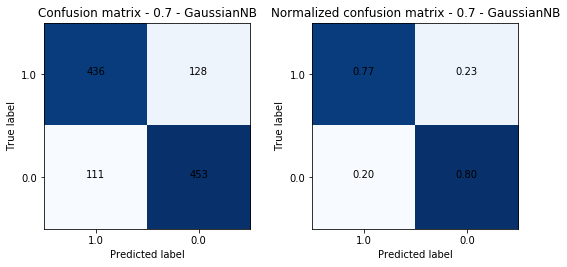

Accuracy for: MultinomialNB : 0.7261
Sensitivity for: MultinomialNB : 0.7340


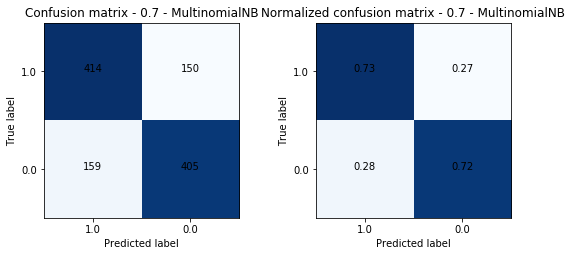

Accuracy for: BernoulyNB : 0.6073
Sensitivity for: BernoulyNB : 0.5762


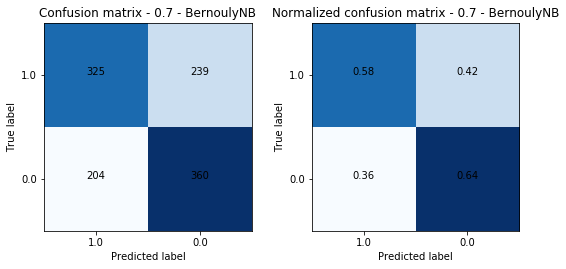

In [4]:
for clf in estimators:
    accuracy[clf] = 0
    sensitivity[clf] = 0
    cnf_mtx[clf] = np.zeros((2, 2)).astype(int)

for train_index, test_index in rskf.split(X_7, y_7):
    X_train, X_test = X_7[train_index], X_7[test_index]
    y_train, y_test = y_7[train_index], y_7[test_index]
    for clf in estimators:
        estimators[clf].fit(X_train, y_train)
        prdY = estimators[clf].predict(X_test)
        accuracy[clf] += metrics.accuracy_score(y_test, prdY)
        sensitivity[clf] += metrics.recall_score(y_test, prdY)
        cnf_mtx[clf] += metrics.confusion_matrix(y_test, prdY, labels_7)
for clf in estimators:
    accuracy[clf] /= n_splits*n_repeats
    sensitivity[clf] /= n_splits*n_repeats
    print("Accuracy for:", clf, ':', format(accuracy[clf], '.4f'))
    print("Sensitivity for:", clf, ':', format(sensitivity[clf], '.4f'))
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
    graph.plot_confusion_matrix(axs[0, 0], cnf_mtx[clf], labels_7, title_complement=('- 0.7 - ' + clf))
    graph.plot_confusion_matrix(axs[0, 1], cnf_mtx[clf], labels_7, normalize=True, title_complement=('- 0.7 - ' + clf))
    plt.tight_layout()
    plt.show()

Accuracy for: GaussianNB : 0.8005
Sensitivity for: GaussianNB : 0.7535


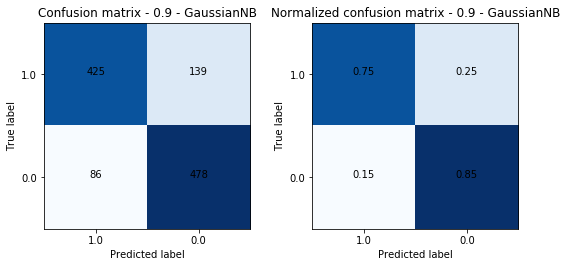

Accuracy for: MultinomialNB : 0.7846
Sensitivity for: MultinomialNB : 0.7819


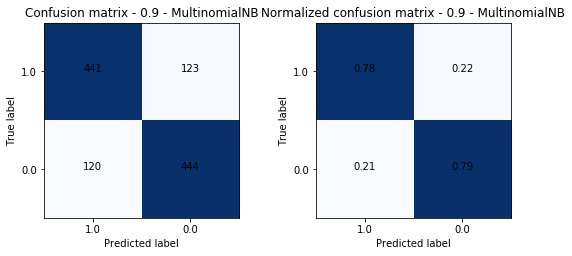

Accuracy for: BernoulyNB : 0.5124
Sensitivity for: BernoulyNB : 0.1684


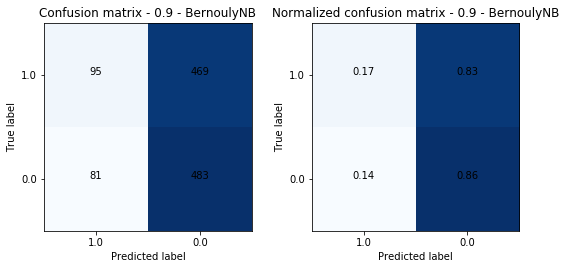

In [5]:
for clf in estimators:
    accuracy[clf] = 0
    sensitivity[clf] = 0
    cnf_mtx[clf] = np.zeros((2, 2)).astype(int)

for train_index, test_index in rskf.split(X_9, y_9):
    X_train, X_test = X_9[train_index], X_9[test_index]
    y_train, y_test = y_9[train_index], y_9[test_index]
    for clf in estimators:
        estimators[clf].fit(X_train, y_train)
        prdY = estimators[clf].predict(X_test)
        accuracy[clf] += metrics.accuracy_score(y_test, prdY)
        sensitivity[clf] += metrics.recall_score(y_test, prdY)
        cnf_mtx[clf] += metrics.confusion_matrix(y_test, prdY, labels_9)
for clf in estimators:
    accuracy[clf] /= n_splits*n_repeats
    sensitivity[clf] /= n_splits*n_repeats
    print("Accuracy for:", clf, ':', format(accuracy[clf], '.4f'))
    print("Sensitivity for:", clf, ':', format(sensitivity[clf], '.4f'))
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
    graph.plot_confusion_matrix(axs[0, 0], cnf_mtx[clf], labels_9, title_complement=('- 0.9 - ' + clf))
    graph.plot_confusion_matrix(axs[0, 1], cnf_mtx[clf], labels_9, normalize=True, title_complement=('- 0.9 - ' + clf))
    plt.tight_layout()
    plt.show()

## KNN
We can try use weights as well

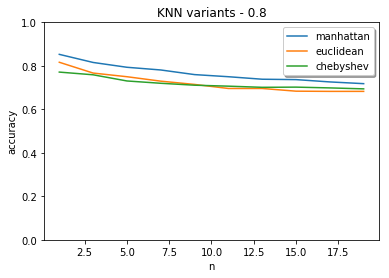

Accuracy for n equal to 1 : 0.8528
Sensitivity for n equal to 1 : 0.7252 

Accuracy for n equal to 3 : 0.8156
Sensitivity for n equal to 3 : 0.6667 

Accuracy for n equal to 5 : 0.7934
Sensitivity for n equal to 5 : 0.6312 

Accuracy for n equal to 7 : 0.7810
Sensitivity for n equal to 7 : 0.5940 

Accuracy for n equal to 9 : 0.7598
Sensitivity for n equal to 9 : 0.5638 

Accuracy for n equal to 11 : 0.7500
Sensitivity for n equal to 11 : 0.5585 

Accuracy for n equal to 13 : 0.7385
Sensitivity for n equal to 13 : 0.5496 

Accuracy for n equal to 15 : 0.7367
Sensitivity for n equal to 15 : 0.5461 

Accuracy for n equal to 17 : 0.7261
Sensitivity for n equal to 17 : 0.5319 

Accuracy for n equal to 19 : 0.7181
Sensitivity for n equal to 19 : 0.5266 



In [6]:
from sklearn.neighbors import KNeighborsClassifier

n_splits = 4
n_repeats = 3
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
recall = {}
for d in dist:
    values[d] = np.zeros(len(nvalues))
    recall[d] = np.zeros(len(nvalues))

for train_index, test_index in rskf.split(X_8, y_8):
    X_train, X_test = X_8[train_index], X_8[test_index]
    y_train, y_test = y_8[train_index], y_8[test_index]
    for d in dist:
        yvalues = []
        recall_values = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(X_train, y_train)
            prdY = knn.predict(X_test)
            yvalues.append(metrics.accuracy_score(y_test, prdY))
            recall_values.append(metrics.recall_score(y_test, prdY))
        values[d] += yvalues
        recall[d] += recall_values
for d in dist:
    values[d] /= (n_splits*n_repeats)
    recall[d] /= (n_splits*n_repeats)
plt.figure()
graph.multiple_line_chart(plt.gca(), nvalues, values, 'KNN variants - 0.8', 'n', 'accuracy', percentage=True)
plt.show()
for aux in range(len(values['manhattan'])):
    print('Accuracy for n equal to', nvalues[aux], ':', format(values['manhattan'][aux], '.4f'))
    print('Sensitivity for n equal to', nvalues[aux], ':', format(recall['manhattan'][aux], '.4f'), '\n')

Manhattan distance resulted in the best accuracy, especially with lower numbers of neighbours.

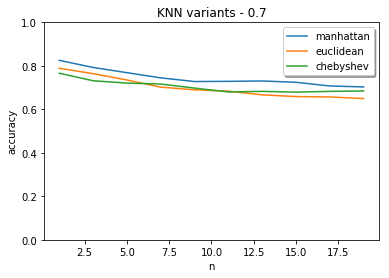

Accuracy for n equal to 1 : 0.8254
Sensitivity for n equal to 1 : 0.6773 

Accuracy for n equal to 3 : 0.7926
Sensitivity for n equal to 3 : 0.6206 

Accuracy for n equal to 5 : 0.7686
Sensitivity for n equal to 5 : 0.5780 

Accuracy for n equal to 7 : 0.7447
Sensitivity for n equal to 7 : 0.5443 

Accuracy for n equal to 9 : 0.7278
Sensitivity for n equal to 9 : 0.5160 

Accuracy for n equal to 11 : 0.7287
Sensitivity for n equal to 11 : 0.5213 

Accuracy for n equal to 13 : 0.7305
Sensitivity for n equal to 13 : 0.5248 

Accuracy for n equal to 15 : 0.7243
Sensitivity for n equal to 15 : 0.5177 

Accuracy for n equal to 17 : 0.7074
Sensitivity for n equal to 17 : 0.4929 

Accuracy for n equal to 19 : 0.7030
Sensitivity for n equal to 19 : 0.4823 



In [7]:
for d in dist:
    values[d] = np.zeros(len(nvalues))
    recall[d] = np.zeros(len(nvalues))

for train_index, test_index in rskf.split(X_7, y_7):
    X_train, X_test = X_7[train_index], X_7[test_index]
    y_train, y_test = y_7[train_index], y_7[test_index]
    for d in dist:
        yvalues = []
        recall_values = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(X_train, y_train)
            prdY = knn.predict(X_test)
            yvalues.append(metrics.accuracy_score(y_test, prdY))
            recall_values.append(metrics.recall_score(y_test, prdY))
        values[d] += yvalues
        recall[d] += recall_values
for d in dist:
    values[d] /= (n_splits*n_repeats)
    recall[d] /= (n_splits*n_repeats)
plt.figure()
graph.multiple_line_chart(plt.gca(), nvalues, values, 'KNN variants - 0.7', 'n', 'accuracy', percentage=True)
plt.show()
for aux in range(len(values['manhattan'])):
    print('Accuracy for n equal to', nvalues[aux], ':', format(values['manhattan'][aux], '.4f'))
    print('Sensitivity for n equal to', nvalues[aux], ':', format(recall['manhattan'][aux], '.4f'), '\n')

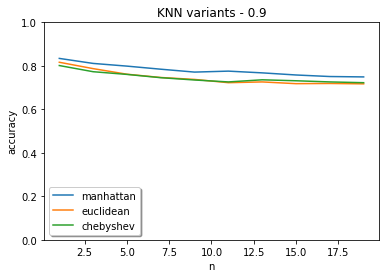

Accuracy for n equal to 1 : 0.8342
Sensitivity for n equal to 1 : 0.6809 

Accuracy for n equal to 3 : 0.8112
Sensitivity for n equal to 3 : 0.6454 

Accuracy for n equal to 5 : 0.7988
Sensitivity for n equal to 5 : 0.6206 

Accuracy for n equal to 7 : 0.7846
Sensitivity for n equal to 7 : 0.5993 

Accuracy for n equal to 9 : 0.7713
Sensitivity for n equal to 9 : 0.5833 

Accuracy for n equal to 11 : 0.7757
Sensitivity for n equal to 11 : 0.5904 

Accuracy for n equal to 13 : 0.7677
Sensitivity for n equal to 13 : 0.5833 

Accuracy for n equal to 15 : 0.7580
Sensitivity for n equal to 15 : 0.5816 

Accuracy for n equal to 17 : 0.7509
Sensitivity for n equal to 17 : 0.5833 

Accuracy for n equal to 19 : 0.7491
Sensitivity for n equal to 19 : 0.5851 



In [8]:
for d in dist:
    values[d] = np.zeros(len(nvalues))
    recall[d] = np.zeros(len(nvalues))

for train_index, test_index in rskf.split(X_9, y_9):
    X_train, X_test = X_9[train_index], X_9[test_index]
    y_train, y_test = y_9[train_index], y_9[test_index]
    for d in dist:
        yvalues = []
        recall_values = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(X_train, y_train)
            prdY = knn.predict(X_test)
            yvalues.append(metrics.accuracy_score(y_test, prdY))
            recall_values.append(metrics.recall_score(y_test, prdY))
        values[d] += yvalues
        recall[d] += recall_values
for d in dist:
    values[d] /= (n_splits*n_repeats)
    recall[d] /= (n_splits*n_repeats)
plt.figure()
graph.multiple_line_chart(plt.gca(), nvalues, values, 'KNN variants - 0.9', 'n', 'accuracy', percentage=True)
plt.show()
for aux in range(len(values['manhattan'])):
    print('Accuracy for n equal to', nvalues[aux], ':', format(values['manhattan'][aux], '.4f'))
    print('Sensitivity for n equal to', nvalues[aux], ':', format(recall['manhattan'][aux], '.4f'), '\n')

KNN with K=1 may result in model too sensitive to outliers, so it may not be the best result. Having more features than records can be one problem, therefore it will be tested the accuracy if we use just the features used for the sparsity plots on 01_Data_exploration.

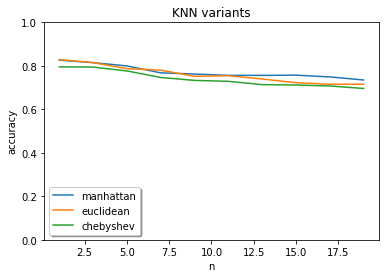

Accuracy for n equal to 1 : 0.8262
Sensitivity for n equal to 1 : 0.7447 

Accuracy for n equal to 3 : 0.8147
Sensitivity for n equal to 3 : 0.7394 

Accuracy for n equal to 5 : 0.7996
Sensitivity for n equal to 5 : 0.7216 

Accuracy for n equal to 7 : 0.7677
Sensitivity for n equal to 7 : 0.7074 

Accuracy for n equal to 9 : 0.7624
Sensitivity for n equal to 9 : 0.7092 

Accuracy for n equal to 11 : 0.7562
Sensitivity for n equal to 11 : 0.6968 

Accuracy for n equal to 13 : 0.7562
Sensitivity for n equal to 13 : 0.6986 

Accuracy for n equal to 15 : 0.7571
Sensitivity for n equal to 15 : 0.6879 

Accuracy for n equal to 17 : 0.7491
Sensitivity for n equal to 17 : 0.6667 

Accuracy for n equal to 19 : 0.7349
Sensitivity for n equal to 19 : 0.6525 



In [9]:
data_test: pd.DataFrame = pd.read_csv('datasets/pd_data_preparation.csv', sep=',', decimal='.', index_col='id')
data_test = data_test[['gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'locPctJitter', 'locShimmer', 'f1', 'mean_MFCC_2nd_coef', 'mean_MFCC_5th_coef', 'std_Log_energy', 'tqwt_energy_dec_17', 'class']]
y_2: np.ndarray = data_test.pop('class').values
X_2: np.ndarray = data_test.values

n_splits = 4
n_repeats = 3
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
recall = {}
for d in dist:
    values[d] = np.zeros(len(nvalues))
    recall[d] = np.zeros(len(nvalues))

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

for train_index, test_index in rskf.split(X_2, y_2):
    X_train, X_test = X_2[train_index], X_2[test_index]
    y_train, y_test = y_2[train_index], y_2[test_index]
    for d in dist:
        yvalues = []
        recall_values = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(X_train, y_train)
            prdY = knn.predict(X_test)
            yvalues.append(metrics.accuracy_score(y_test, prdY))
            recall_values.append(metrics.recall_score(y_test, prdY))
        values[d] += yvalues
        recall[d] += recall_values
for d in dist:
    values[d] /= (n_splits*n_repeats)
    recall[d] /= (n_splits*n_repeats)
plt.figure()
graph.multiple_line_chart(plt.gca(), nvalues, values, 'KNN variants', 'n', 'accuracy', percentage=True)
plt.show()

for aux in range(len(values['manhattan'])):
    print('Accuracy for n equal to', nvalues[aux], ':', format(values['manhattan'][aux], '.4f'))
    print('Sensitivity for n equal to', nvalues[aux], ':', format(recall['manhattan'][aux], '.4f'), '\n')

With these features, the accuracy is a little worse, but there is a gain on sensitivity, which is important for a medical problem, since we would rather get false positives than false negatives.

Another consideration: the K = 1 can indicate that each feature contribute a little to the result, then getting only the nearest neighbour results the best prediction in this case.